<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/notebooks/practica_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 8

- Selección de modelos
- Sobrejuste
- Validación cruzada
- Criterios de información

In [1]:
import io
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install pymc
import pymc as pm
import arviz as az
import pandas as pd

### Dataset 1: Resistencia de una mezcla de hormigón

fuente: https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Concrete_Data.csv to Concrete_Data.csv


In [3]:
#Se crea un DataFrame
df_hormigon = pd.read_csv(io.BytesIO(uploaded['Concrete_Data.csv']))
df_hormigon.head()

,Cement (kg/m3),Blast Furnace Slag (kg/m3),Fly Ash (kg/m3),Water (kg/m3),Superplasticizer (kg/m3),Coarse Aggregate (kg/m3),Fine Aggregate (kg/m3),Age (day),Concrete compressive strength (MPa)
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [4]:
np.unique( df_hormigon['Age (day)'])

array([  1,   3,   7,  14,  28,  56,  90,  91, 100, 120, 180, 270, 360,
       365])

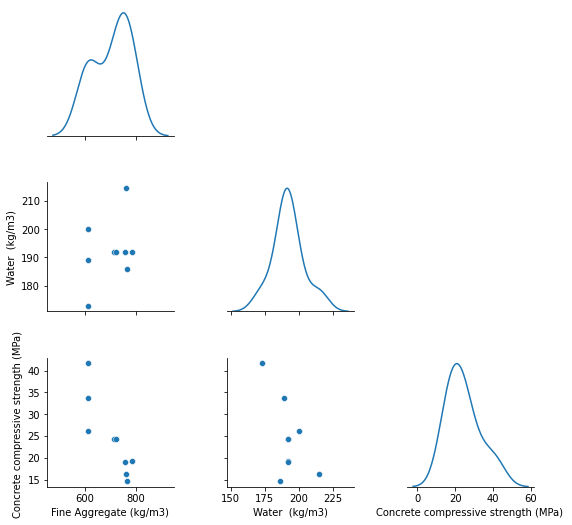

In [5]:
g = sns.PairGrid( df_hormigon.query(" `Blast Furnace Slag (kg/m3)` == 0 and `Superplasticizer (kg/m3)` == 0 and `Age (day)` == 3 and `Fly Ash (kg/m3)` == 0 and `Cement (kg/m3)` >= 350" ),
                  diag_sharey=False, corner=True,
                  vars=['Fine Aggregate (kg/m3)','Water  (kg/m3)','Concrete compressive strength (MPa) '] )
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.add_legend();

### Dataset 2: Frecuencia natural de galpones industriales

fuente: Santiago Bertero, Virginia Tech

In [6]:
from google.colab import files
uploaded = files.upload()

Saving Galpones.csv to Galpones.csv


In [7]:
#Se crea un DataFrame
df_galpones = pd.read_csv(io.BytesIO(uploaded['Galpones.csv']))
df_galpones.head()

,Frame,W_kip_,Height_in_,L_ft_,alpha,Cladding,Structure,Roof,Seismic,Wind,Weights,k_lat_kip_ft_,MassParticipation,T_model_s_,T_r1_s_,T_r2_s_,T_S_U_s_
0,1,10.21,190.0,40,2.526,Metal Panels,Clear Span,Monoslope,Low,High,0.011666,3.520,0.933,0.546,0.546,0.545,0.707386
1,2,25.16,192.5,100,6.234,Metal Panels,Clear Span,Gabled,Low,High,0.032986,12.459,0.619,0.571,0.560,0.454,0.537498
2,3,46.71,220.0,160,8.727,Metal Panels,Clear Span,Monoslope,High,High,0.001667,27.663,0.423,0.606,0.580,0.415,0.423907
3,4,13.14,400.0,40,1.200,Metal Panels,Clear Span,Gabled,Low,High,0.002174,3.563,0.930,0.602,0.602,0.614,0.953937
4,5,52.23,385.0,100,3.117,Metal Panels,Clear Span,Monoslope,High,Low,0.001058,7.218,0.925,0.881,0.880,0.860,1.208260


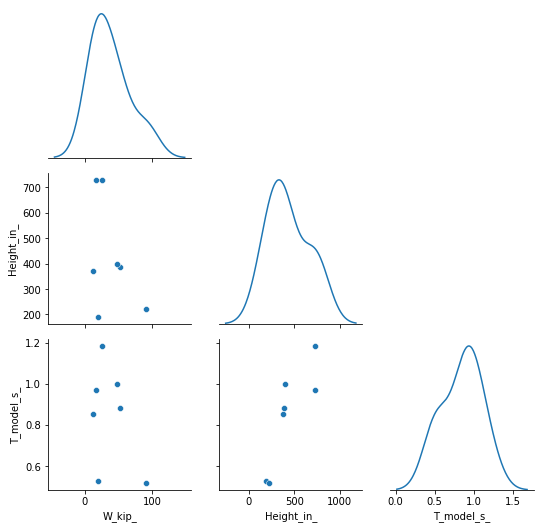

In [8]:
g = sns.PairGrid( df_galpones.query(" `Cladding` == 'Metal Panels' and `Structure` == 'Clear Span' and `Seismic` == 'Low'  and `Wind` == 'Low' and `Roof` == 'Monoslope' "),
                  diag_sharey=False, corner=True,
                  vars=['W_kip_','Height_in_','T_model_s_'] )
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.add_legend();

### Dataset 3: Punzonado en losas

fuente: Maya et al (2012), Punching shear strength of steel fibre reinforced concrete slabs (DOI 10.1016/j.engstruct.2012.02.009)

In [9]:
from google.colab import files
uploaded = files.upload()

Saving punzonado_losas.csv to punzonado_losas.csv


In [10]:
#Se crea un DataFrame
df_punzonado = pd.read_csv(io.BytesIO(uploaded['punzonado_losas.csv']))
df_punzonado.head()

,Specimen,h(mm),d(mm),bca(mm),fc(MPa),rho(%),rhof(%),Vexp(kN),VexpVR/est1b,VexpVR/est2c,VexpVR/d-d
0,S1,152,127.0,152,47.7,0.98,0.0,433.0,1.10,1.19,1.38
1,S2,152,127.0,152,47.7,0.66,0.0,379.0,1.16,1.22,1.42
2,S3/FRC,152,127.0,152,25.4,0.98,1.0,386.0,1.01,1.09,1.25
3,S4/FRC,152,127.0,152,25.4,0.66,1.0,389.0,1.15,1.20,1.37
4,S5/FRM,152,127.0,152,59.3,0.98,1.5,530.0,1.03,1.12,1.27


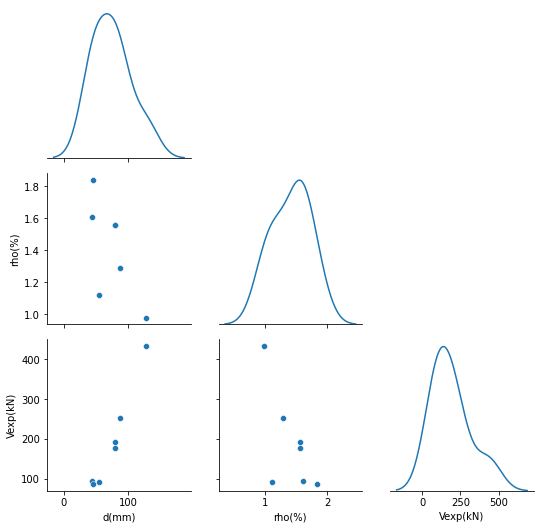

In [11]:
g = sns.PairGrid( df_punzonado.query(" `rhof(%)` == 0 and `rho(%)` > 0.9 and `fc(MPa)` > 30 "),
                  diag_sharey=False, corner=True,
                  vars=['d(mm)','rho(%)','Vexp(kN)'] )
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.add_legend();

## Funciones

### Gráficos de diagnóstico

In [12]:
# Función de cálculo y ploteo de residuos
def residuals_plot( trace, y_obs, mu, ax=None ):

  # Residuos
  residuals = y_obs - trace.posterior[mu]

  # Predicción posterior media de y
  mu_mean = trace.posterior[mu].mean( ['chain','draw'] ).to_numpy()

  # Intervalos de confianza
  residuals_hdi = az.hdi( residuals, hdi_prob=0.9 )
  residuals_mean = residuals.mean(['chain','draw'])

  # Gráfico
  if not ax:
    fig, ax = plt.subplots( figsize=(7,7) )
  
  # Residuos
  ax.hlines( y=0, xmin=mu_mean.min(), xmax=mu_mean.max(),
              colors='grey', linestyle='--' )
  ax.errorbar( mu_mean, residuals_mean,
               yerr=np.abs( residuals_mean-residuals_hdi )[mu].T,
               fmt='C0o',
               ecolor='grey', alpha=.6 )

  # Formateo
  ax.set_xlabel('predicción media de y', fontsize=14)
  ax.set_ylabel('residuo', fontsize=14)

  return residuals

In [13]:
def posterior_pred_check( trace, y='y', ax=None ):

  # Observaciones
  y_observed = trace.observed_data[y]

  # HDI intervalo de confianza de mu
  mu_hdi = az.hdi( trace.posterior_predictive[y], hdi_prob=0.9 )
  # Media de observaciones
  y_mean = trace.posterior_predictive[y].mean( ['chain','draw'] ).to_numpy()

  if not ax:
    fig, ax = plt.subplots( figsize=(7,7) )
      
  # recta diagonal
  min_x, max_x = y_observed.min(), y_observed.max()
  ax.plot([min_x, max_x], [min_x, max_x], 'k--')
  # Errores
  ax.errorbar( y_observed, y_mean,
               yerr=np.abs(y_mean-mu_hdi[y].T), fmt='C0o',
               alpha=.5, ecolor='grey' )
  # Labels
  ax.set_xlabel('y observado', fontsize=14)
  ax.set_ylabel('y predicción', fontsize=14)

  return ax

In [14]:
def plot_lm( trace, x_obs, y_obs, mu, y, ax=None):

  if not ax:
    fig, ax = plt.subplots( figsize=(7,7) )

  # Línea media
  ix = np.argsort(x)
  ax.plot( x[ix], trace.posterior[mu].mean(['chain','draw'])[ix],'k--')

  # HDI de observaciones
  az.plot_hdi( x, trace.posterior_predictive[y], color='C2', ax=ax )

  # HDI de mu
  az.plot_hdi( x, trace.posterior[mu], color='C1', ax=ax )

  # Observaciones
  ax.scatter( x_obs, y_obs, alpha=.5 )

  # Formateo
  ax.set_xlabel('x', fontsize=14)
  ax.set_ylabel('y', fontsize=14)

  return ax

### Métricas de ajuste

In [15]:
# R squared
def rsquared( trace, y_obs, mu ):

  # Simulaciones posteriores de mu
  mu_post = trace.posterior[mu].mean(['chain','draw'])

  # Residuos
  residuals = y_obs - mu_post

  # Rsq
  tss = ( y - y.mean() ).var()
  rss = np.var( residuals, axis=0 )
  R2 = 1 - rss / tss

  return R2.values

In [16]:
# LPPD
def lppd( trace, y='y' ):

  # Log-likelihood
  logl = trace.log_likelihood[y]
  # Predictive mean
  l_mean = np.exp( logl ).mean(['chain','draw'])
  # Predictive log-likelihood
  lppdi = np.log( l_mean ).values

  return lppdi.sum(), lppdi

### Funciones para ajuste de polinomios y MCMC

In [ ]:
def create_poly_model( xtrain, ytrain, sigma, degree=1 ):

  with pm.Model() as model:
      
    # Data modificable
    X = pm.MutableData( 'X', xtrain )
    Y = pm.ConstantData( 'Y', ytrain )

    # Priors
    alpha = pm.Normal( "alpha", mu=0, sigma=sigma )
    beta = pm.Normal( "beta", mu=0, sigma=sigma, shape=degree )
    log_sigma = pm.Normal( "log_sigma", mu=0, sigma=1 )
    
    # Mean
    B = pm.math.stack([X**(i+1) for i in range(degree)])
    mu = pm.Deterministic( 'mu', alpha + pm.math.dot( B.T, beta ) )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=np.exp(log_sigma), observed=Y )

  return model

In [ ]:
def run_mcmc( model, xtest, mu='mu', y='y' ):

  with model:

    # Posterior de los parámetros
    trace = pm.sample( 3000, tune=2000, cores=2 )
  
    # Posterior predictive
    pm.set_data({"X": xtest})
    pm.sample_posterior_predictive( trace, var_names=[mu,y],
                                    extend_inferencedata=True);

  return trace

In [ ]:
def quap( model, xtest, n_samples=1000 ):

  with model:
    map = pm.find_MAP()
    H = pm.find_hessian(map)
    
    cov = np.linalg.inv(H)
    mean = np.concatenate([np.atleast_1d(map[v.name]) for v in model.value_vars])
    posterior = st.multivariate_normal(mean=mean, cov=cov)
    
    # Posterior draws
    x_obs = model.X.eval()
    y_obs = model.Y.eval()
    
    draws = posterior.rvs(n_samples)[np.newaxis, ...]  
    # mu
    degree = mean.shape[0] - 2
    B = np.stack([x_obs**(i+1) for i in range(degree)])
    bb = draws[:,:,1:-1].dot( B )
    mu_draws = np.array([draws[:,:,0] + bb[:,:,i] for i in range(x_obs.size)])
    mu_draws = np.moveaxis( mu_draws, 0, -1 )

    # Loglikelihood
    ss = np.exp(draws[:,:,-1])
    logl = np.array([st.norm.logpdf( y_obs[i], loc=mu_draws[:,:,i], scale=ss ) for i in range(x_obs.size) ])
    logl = np.moveaxis( logl, 0, -1 )
    
    # Predictive posterior draws
    B = np.stack([xtest**(i+1) for i in range(degree)])
    bb = draws[:,:,1:-1].dot( B )
    mu_draws_pred = np.array([draws[:,:,0] + bb[:,:,i] for i in range(xtest.size)])
    mu_draws_pred = np.moveaxis( mu_draws_pred, 0, -1 )
    
    y_draws = np.array([st.norm.rvs( size=n_samples, loc=mu_draws_pred[:,:,i], scale=ss ) for i in range(xtest.size)])
    y_draws = y_draws[ np.newaxis, ... ]
    y_draws = np.moveaxis( y_draws, 1, -1 )

    #
    if draws.ndim == 2:
        draws = draws[..., np.newaxis]
    samples = {}
    samples['mu'] = mu_draws
    i = 0

    # Posterior
    for v in model.value_vars:
        var_size = map[v.name].size
        samples[v.name] = draws[:, :, i: i + var_size]
        if var_size == 1:
            samples[v.name] = samples[v.name].squeeze(axis=-1)
        i += var_size
    # Posterior predictive
    samples_pred = {}
    samples_pred['y'] = y_draws
    samples_pred['mu'] = mu_draws_pred
    # samples_pred['log_likelihood'] = logl_pred
    # loglikelihood
    samples_logl = {}
    samples_logl['y'] = logl
      
  idata = az.convert_to_inference_data( samples, group='posterior')
  idata.add_groups( {'posterior_predictive':samples_pred } )
  idata.add_groups( {'log_likelihood':samples_logl } )

  return idata

## Ejemplo 1: diagnóstico de No linealidad con el predictor

In [17]:
x = df_hormigon['Age (day)'].to_numpy()
x = (x-x.mean())/x.std()
y = df_hormigon['Concrete compressive strength (MPa) '].to_numpy()
y = (y-y.mean())/y.std()

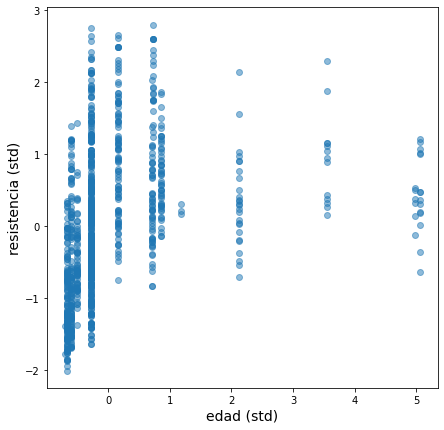

In [165]:
fig, ax = plt.subplots( figsize=(7,7) )
ax.scatter( x, y, alpha=.5 )
ax.set_xlabel('edad (std)', fontsize=14)
ax.set_ylabel('resistencia (std)', fontsize=14);

In [166]:
# modelo solo con x (sin término cuadrático)
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x )  
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_ej1 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej1, extend_inferencedata=True )

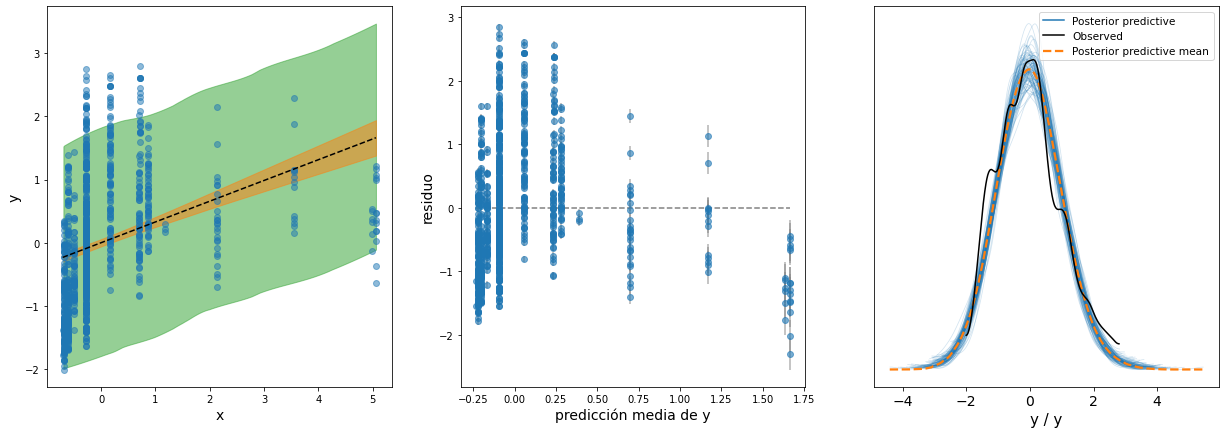

In [173]:
fig, ax = plt.subplots( figsize=(21,7), ncols=3 )
_ = plot_lm( trace_ej1, x, y, 'mu', 'y', ax=ax[0] )
_ = residuals_plot( trace_ej1, y, 'mu', ax=ax[1])
_ = az.plot_ppc( trace_ej1, num_pp_samples=100, ax=ax[2], textsize=14 );

In [174]:
# modelo solo con x (con término cuadrático)
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x + beta2 * x**2 )  
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_ej12 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej12, extend_inferencedata=True )

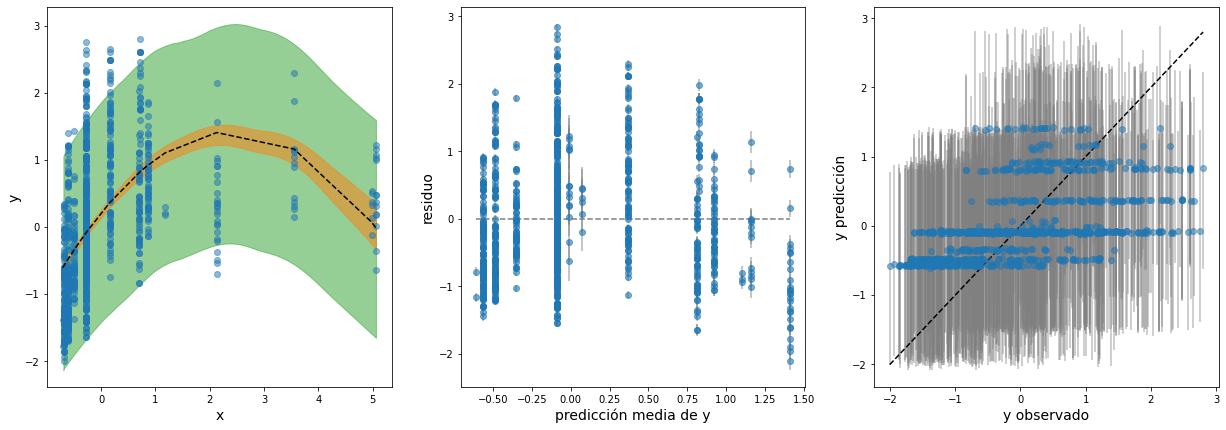

In [175]:
fig, ax = plt.subplots( figsize=(21,7), ncols=3 )
_ = plot_lm( trace_ej12, x, y, 'mu', 'y', ax=ax[0] )
_ = residuals_plot( trace_ej12, y, 'mu', ax=ax[1])
_ = posterior_pred_check( trace_ej12, y='y', ax=ax[2] )
# _ = az.plot_ppc( trace_ej12, num_pp_samples=100, ax=ax[2], textsize=14 );

In [176]:
x2 = df_hormigon['Cement (kg/m3)'].to_numpy()
x2 = (x2-x2.mean())/x2.std()

# modelo solo con x (con término cuadrático)
with pm.Model() as model:
    
    # Priors
    beta = pm.Normal( "beta0", mu=0, sigma=2, shape=4 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta[0] + beta[1] * x + beta[2] * x**2 + beta[3] * x2 )  
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_ej13 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej13, extend_inferencedata=True )

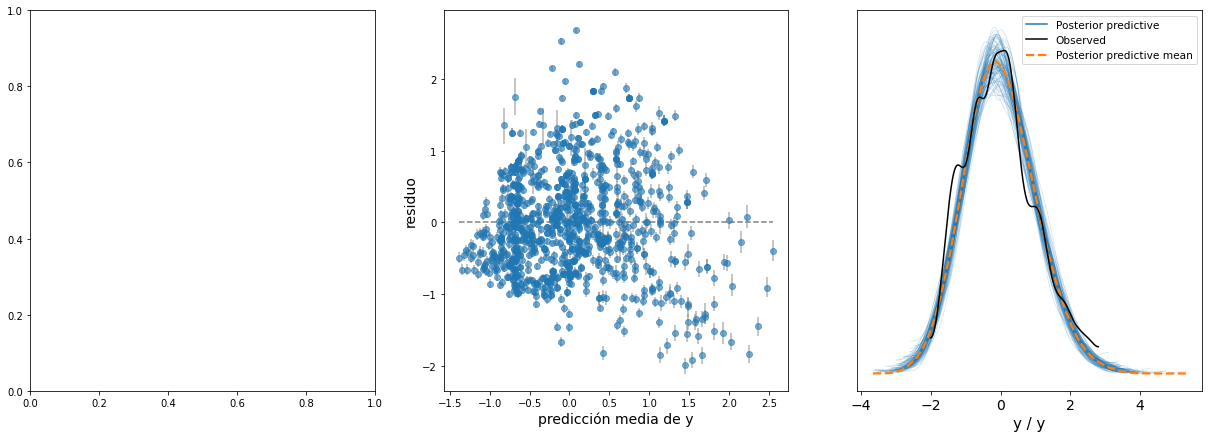

In [179]:
fig, ax = plt.subplots( figsize=(21,7), ncols=3 )
# _ = plot_lm( trace_ej13, x, y, 'mu', 'y', ax=ax[0] )
_ = residuals_plot( trace_ej13, y, 'mu', ax=ax[1])
# _ = posterior_pred_check( trace_ej13, y='y', ax=ax[2] )
_ = az.plot_ppc( trace_ej13, num_pp_samples=100, ax=ax[2], textsize=14 );

In [181]:
# Modelo 1 (solo x sin término cuadrático)
R2_1 = rsquared( trace_ej1, y, 'mu' )
RMSE_1 = trace_ej1.posterior['sigma'].mean(['chain','draw'])

# Modelo 1 (solo x sin término cuadrático)
R2_2 = rsquared( trace_ej12, y, 'mu' )
RMSE_2 = trace_ej12.posterior['sigma'].mean(['chain','draw'])

# Modelo 1 (solo x sin término cuadrático)
R2_3 = rsquared( trace_ej13, y, 'mu' )
RMSE_3 = trace_ej13.posterior['sigma'].mean(['chain','draw'])

print( R2_1.mean(), RMSE_1 )
print( R2_2.mean(), RMSE_2 )
print( R2_3.mean(), RMSE_3 )

0.10815723272205713 <xarray.DataArray 'sigma' ()>
array(0.94619993)
0.2567548747390318 <xarray.DataArray 'sigma' ()>
array(0.86364889)
0.488691751811521 <xarray.DataArray 'sigma' ()>
array(0.7172902)


## Ejemplo 2: diagnóstico de heteroscedasticidad

In [199]:
x = df_punzonado['d(mm)'].to_numpy()
x = (x-x.mean())/x.std()
y = df_punzonado['Vexp(kN)'].to_numpy()

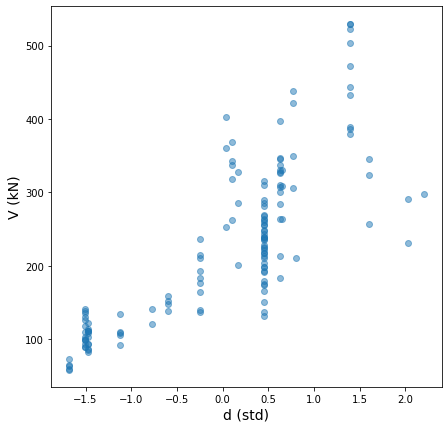

In [201]:
fig, ax = plt.subplots( figsize=(7,7) )
ax.scatter( x, y, alpha=.5 )
ax.set_xlabel('d (std)', fontsize=14)
ax.set_ylabel('V (kN)', fontsize=14);

In [207]:
# modelo homoscedástico
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=100 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=10 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x )  
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_ej21 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej21, extend_inferencedata=True )

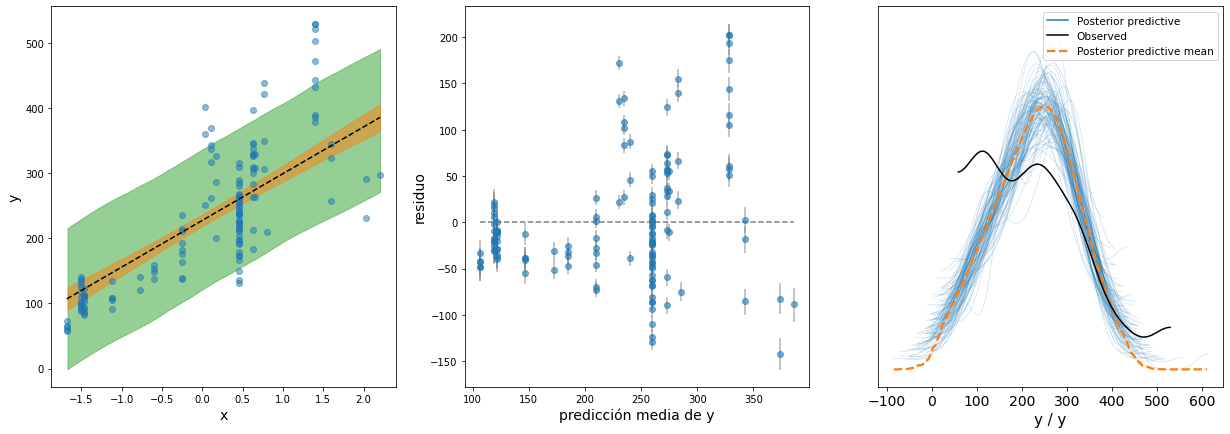

In [208]:
fig, ax = plt.subplots( figsize=(21,7), ncols=3 )
_ = plot_lm( trace_ej21, x, y, 'mu', 'y', ax=ax[0] )
_ = residuals_plot( trace_ej21, y, 'mu', ax=ax[1])
_ = az.plot_ppc( trace_ej21, num_pp_samples=100, ax=ax[2], textsize=14 );

In [209]:
# modelo heteroscedástico
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=100, sigma=100 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=10 )
    d0 = pm.Normal( "d0", mu=0, sigma=1 )
    d1 = pm.Normal( "d1", mu=0, sigma=1 )

    # Desvío
    log_sigma = pm.Deterministic( "sigma", d0 + d1 * x )
    
    # Media
    mu = pm.Deterministic('mu', beta0 + beta1 * x )  
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=np.exp(log_sigma), observed=y )
      
    # Posterior de los parámetros
    trace_ej22 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej22, extend_inferencedata=True )

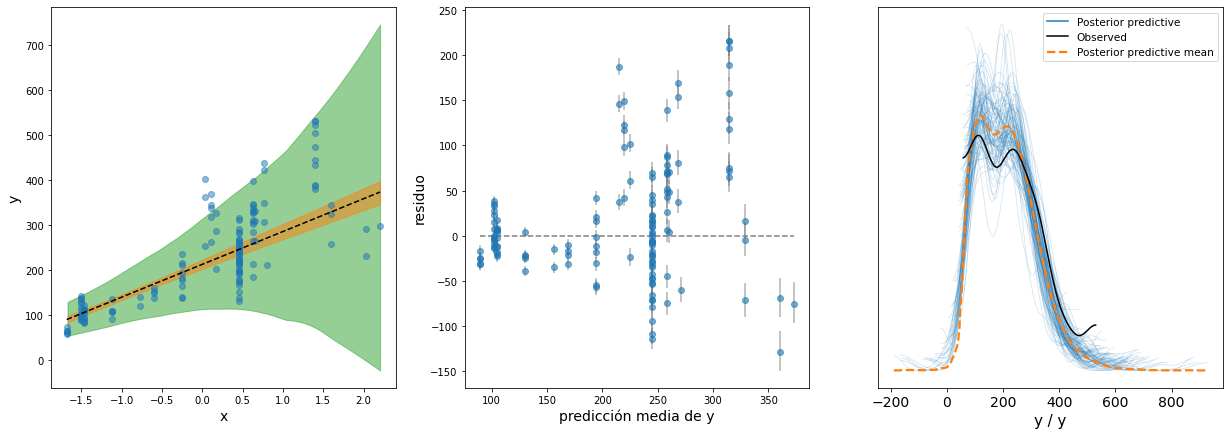

In [210]:
fig, ax = plt.subplots( figsize=(21,7), ncols=3 )
_ = plot_lm( trace_ej22, x, y, 'mu', 'y', ax=ax[0] )
_ = residuals_plot( trace_ej22, y, 'mu', ax=ax[1])
_ = az.plot_ppc( trace_ej22, num_pp_samples=100, ax=ax[2], textsize=14 );

In [211]:
# modelo heteroscedástico
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=100, sigma=100 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=10 )
    d0 = pm.Normal( "d0", mu=0, sigma=1 )
    
    # Media
    mu = pm.Deterministic('mu', beta0 + beta1 * x )  
    
    # Desvío
    sigma = pm.Deterministic( "sigma", d0 * mu )

    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
      
    # Posterior de los parámetros
    trace_ej23 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej23, extend_inferencedata=True )

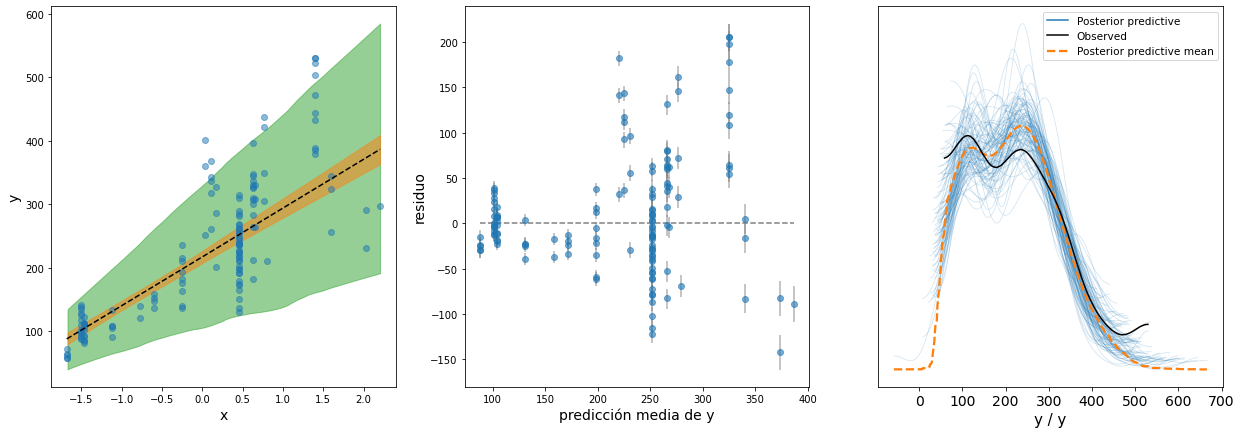

In [212]:
fig, ax = plt.subplots( figsize=(21,7), ncols=3 )
_ = plot_lm( trace_ej23, x, y, 'mu', 'y', ax=ax[0] )
_ = residuals_plot( trace_ej23, y, 'mu', ax=ax[1])
_ = az.plot_ppc( trace_ej23, num_pp_samples=100, ax=ax[2], textsize=14 );

In [256]:
# modelo homoscedástico de log
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    logmu = pm.Deterministic('logmu', beta0 + beta1 * x )
    
    # Modelo
    logY = pm.Normal( "logy", mu=logmu, sigma=sigma, observed=np.log(y) )

    # Valores para y (sin log)
    mu = pm.Deterministic('mu', np.exp(logmu+sigma**2/2))
    Y = pm.LogNormal( "y", mu=logmu, sigma=sigma )
      
    # Posterior de los parámetros
    trace_ej24 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej24, var_names=['logy','y'],
                                    extend_inferencedata=True )

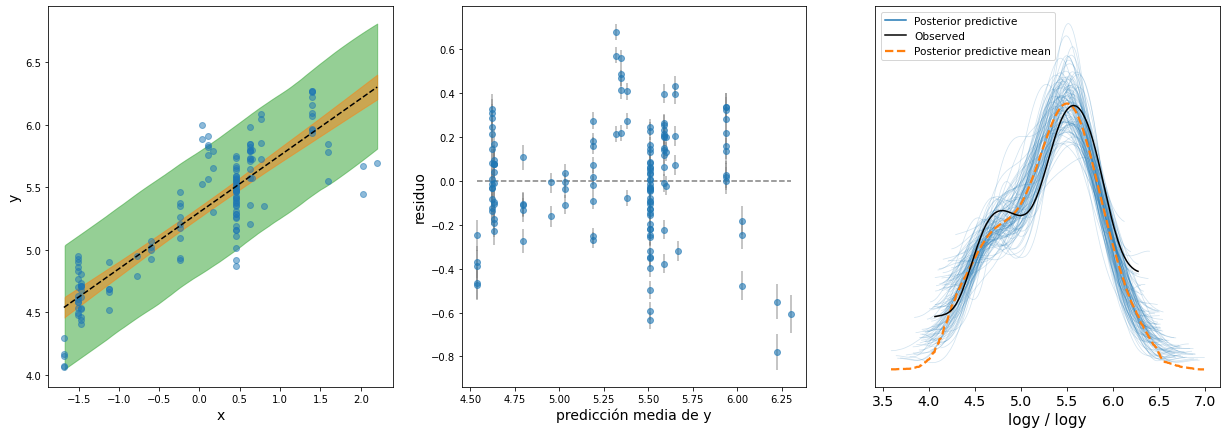

In [221]:
fig, ax = plt.subplots( figsize=(21,7), ncols=3 )
_ = plot_lm( trace_ej24, x, np.log(y), 'logmu', 'logy', ax=ax[0] )
_ = residuals_plot( trace_ej24, np.log(y), 'logmu', ax=ax[1])
_ = az.plot_ppc( trace_ej24, num_pp_samples=100, ax=ax[2], textsize=14 );

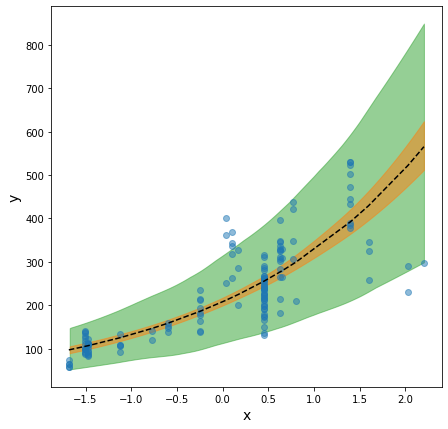

In [224]:
plot_lm( trace_ej24, x, y, 'mu', 'y' )

In [247]:
# Modelo 1
R2_1 = rsquared( trace_ej21, y, 'mu' )
lppd_1 = lppd( trace_ej21, 'y' )

# Modelo 2
R2_2 = rsquared( trace_ej22, y, 'mu' )
lppd_2 = lppd( trace_ej22, 'y' )

# Modelo 3
R2_3 = rsquared( trace_ej23, y, 'mu' )
lppd_3 = lppd( trace_ej23, 'y' )

# Modelo 4
R2_4 = rsquared( trace_ej24, np.log(y), 'logmu' )
lppd_4 = lppd( trace_ej24, 'logy' )

print( R2_1.mean(), lppd_1[0] )
print( R2_2.mean(), lppd_2[0] )
print( R2_3.mean(), lppd_3[0] )
print( R2_4.mean(), lppd_4[0] )

0.6241245197300266 -791.8978245471727
0.626954861410137 -754.3844146741034
0.6359579530171364 -755.8506981128053
0.9999944460365289 -9.750463553878525


## Ejemplo extra: Scoring rules

In [ ]:
# Observaciones sintéticas
np.random.seed(19102022)
N = 40
x = st.norm.rvs( size=N, loc=0, scale=1 )
x = (x-x.mean())/x.std()
y = st.norm.rvs( size=N, loc=1+0.5*x, scale=0.5)
y = (y-y.mean())/y.std()

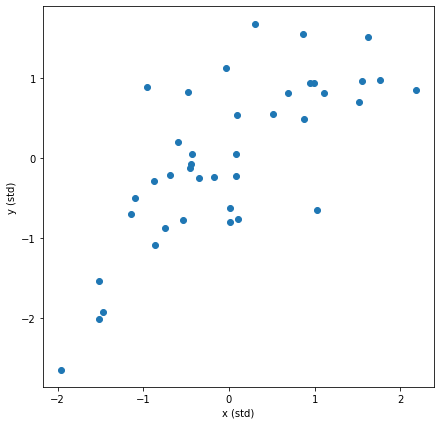

In [ ]:
fig, ax = plt.subplots( figsize=(7,7) )
ax.scatter( x, y )
ax.set_xlabel('x (std)')
ax.set_ylabel('y (std)');

In [ ]:
with pm.Model() as model:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=2 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', beta0 + beta1 * x )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=y )

    # Posterior de los parámetros
    trace_ej2 = pm.sample( 3000, tune=2000, cores=2 )
    
    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej2, extend_inferencedata=True )

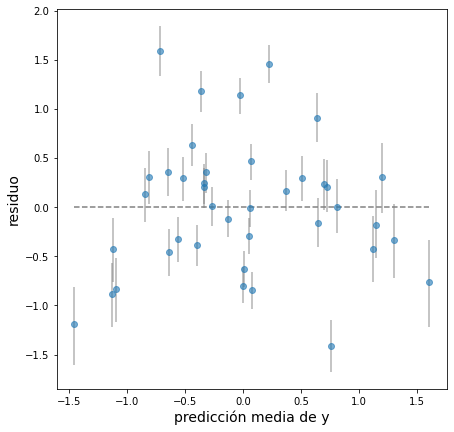

In [ ]:
_ = residuals_plot( trace_ej2, y, 'mu' )

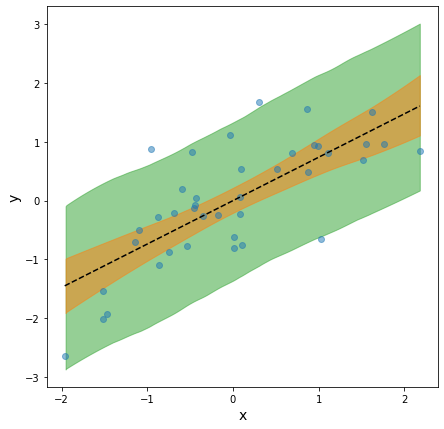

In [ ]:
_ = plot_lm( trace_ej2, x, y, 'mu', 'y' )

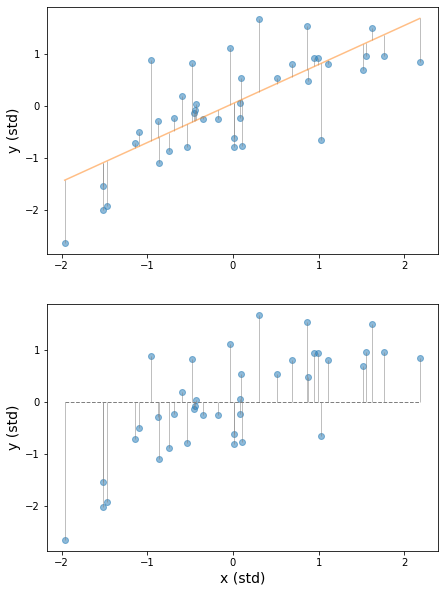

In [ ]:
fig, ax = plt.subplots( figsize=(7,10), nrows=2 )

# Simulaciones posteriores de mu
ix = np.argsort(x)
rnd = np.random.choice( 3000, size=1 )
recta_i = trace_ej2.posterior['mu'][1,rnd,:].T
ax[0].plot( x[ix], recta_i[ix], color='C1', alpha=.5 )
# ax[1].plot( x[ix], recta_i[ix], color='C1', alpha=.5 )

# Observaciones
ax[0].scatter( x, y, alpha=.5 )
ax[1].scatter( x, y, alpha=.5 )

# varianza total
ax[1].hlines( y=0, xmin=x.min(), xmax=x.max(),
           linewidth=1, linestyle='--', color='gray' )
ax[1].vlines( x, 0, y, colors='grey',
           linewidth=1, linestyle='-', color='gray', alpha=.5)

# varianza de residuos
ax[0].vlines( x, ymin=recta_i, ymax=y, colors='grey', linewidth=1, alpha=.5)

# Formateo
ax[0].set_ylabel('y (std)', fontsize=14)
ax[1].set_xlabel('x (std)', fontsize=14)
ax[1].set_ylabel('y (std)', fontsize=14);

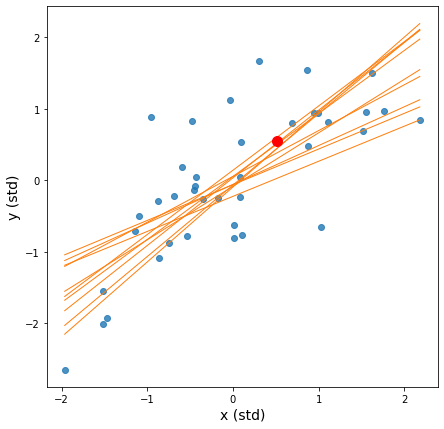

In [ ]:
fig, ax = plt.subplots( figsize=(7,7) )

# Linea posterior
mu_post = trace_ej2.posterior['mu'][0,:,:]

# Línea media
ix = np.argsort(x)
ax.plot( x[ix], mu_post[100:110,ix].T,'C1-', linewidth=1)

# Simulaciones posteriores predictivas
# ax.plot( x, trace_ej2.posterior_predictive['y'].stack(sample=['chain','draw']),
#          'C1o', alpha=.2, markersize=2 )

# Densidad
s_ix = trace_ej2.posterior['sigma'].mean(['chain','draw'])
obs_ixs = [-10,10,13,16]
obs_ixs = [-10]

xplot = np.arange(-2.5,2.1,0.1)
for obs_ix in obs_ixs:
  # Valor medio
  m_ix = mu_post[100,obs_ix]
  # Densidad de probabildiad
  # ax.vlines( x=x[obs_ix], ymin=-2.5, ymax=2, linestyle='--', color='gray' )
  # ax.fill_betweenx( x1=x[obs_ix]*np.ones(xplot.size),
  #                   x2=x[obs_ix] + st.norm.pdf( xplot, loc=m_ix, scale=s_ix ),
  #                   y=xplot,
  #                   color='gray', alpha=0.5)
  # Resaltar observacion
  ax.plot( x[obs_ix], y[obs_ix], 'ro', markersize=10 )
  # Densidad para la observacion
  # ax.hlines( y=y[obs_ix], xmin=x[obs_ix],
  #            xmax=x[obs_ix] + st.norm.pdf( y[obs_ix], loc=m_ix, scale=s_ix ),
  #            color='r', linewidth=2 )

# Observaciones
ax.scatter( x, y, alpha=.8, color='C0' )

# Formateo
ax.set_xlabel('x (std)', fontsize=14)
ax.set_ylabel('y (std)', fontsize=14);

## Ejemplo 3: Ajuste resistencia a 3 días

### Ajuste in-sample

In [258]:
df_ej3 = df_hormigon.query(" `Blast Furnace Slag (kg/m3)` == 0 and `Superplasticizer (kg/m3)` == 0 and `Age (day)` == 3 and `Fly Ash (kg/m3)` == 0 and `Cement (kg/m3)` >= 350" )
df_ej3 = df_ej3.drop_duplicates( 'Cement (kg/m3)' )
x = df_ej3['Cement (kg/m3)'].to_numpy()
x = (x - x.mean())/x.std()
y = df_ej3['Concrete compressive strength (MPa) '].to_numpy()
y = (y - y.mean())/y.std()

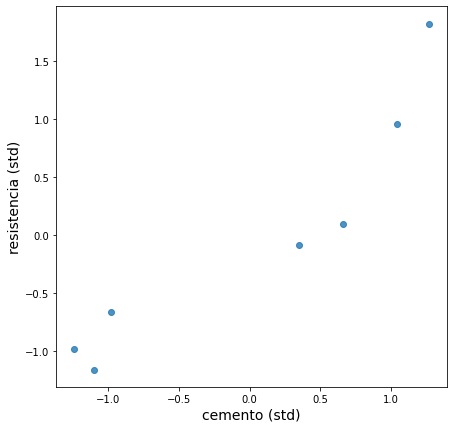

In [259]:
np.random.seed( 243 )
fig, ax = plt.subplots( figsize=(7,7) )
# ixr = np.random.choice( x.size, size=7, replace=False )
ax.scatter( x, y, alpha=.8 )
ax.set_xlabel('cemento (std)', fontsize=14)
ax.set_ylabel('resistencia (std)', fontsize=14);

In [264]:
# grados de los polinomios
grados = [1,2,3,4,5,6]

# x para plotear bien las funciones de regresión
xtest = np.arange(-1.5,2,0.1)

# Ajuste de los modelos polinómico
traces_ej3 = []
R2s = []
lppds = []
for grado in grados:
  
  # Creación del modelo
  model_i = create_poly_model( x, y, 10, degree=grado )

  # Ajuste del modelo por aproximación cuadrática
  trace_i = quap( model_i, xtest, n_samples=3000 )

  # Guardar modelo y calcular métricas de ajuste
  traces_ej3 += [trace_i]
  R2s += [rsquared( trace_i, y, 'mu' ).mean() ]
  lppds += [ lppd( trace_i, y='y' )[0] ]

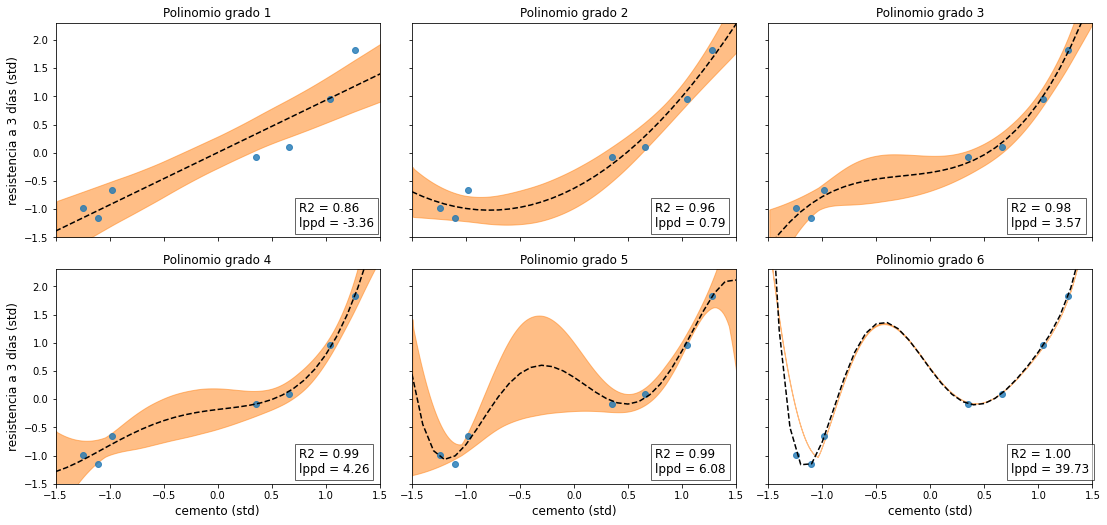

In [265]:
# Función para plotear todo lindo
fig, ax = plt.subplots( figsize=(18,8), ncols=3, nrows=2, sharey=True, sharex=True )
fig.subplots_adjust( left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1,
                     hspace=0.15)

for i in range(len(traces_ej3)):
  row = i//3
  col = i - row * 3
  # Línea media
  ix = np.argsort(x)
  ax[row,col].plot( xtest,
              traces_ej3[i].posterior_predictive['mu'].mean(['chain','draw']).T,
              'k--')
  # HDI de mu
  az.plot_hdi( xtest, traces_ej3[i].posterior_predictive['mu'], color='C1', ax=ax[row,col] )

  # Observaciones
  ax[row,col].scatter( x, y, alpha=.8, color='C0' )

  # Leyenda
  ax[row,col].text( 0.75, 0.05, 'R2 = {:.2f}\nlppd = {:.2f}'.format( R2s[i],lppds[i] ),
                    transform=ax[row,col].transAxes, fontsize=12,
                    bbox=dict(facecolor='w', alpha=.6) )

  # Formateo
  ax[row,col].set_xlim([-1.5,1.5])
  ax[row,col].set_ylim([-1.5,2.3])
  if row==1: ax[row,col].set_xlabel('cemento (std)', fontsize=12)
  if col==0: ax[row,col].set_ylabel('resistencia a 3 días (std)', fontsize=12)
  ax[row,col].set_title('Polinomio grado {}'.format(str(i+1)));

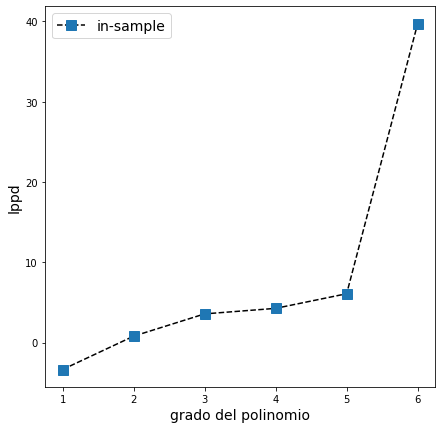

In [272]:
fig, ax = plt.subplots( figsize=(7,7) )

ax.plot( np.arange(1,7), lppds, 'k--', marker='s', label='in-sample',
         markerfacecolor='C0', markeredgecolor='C0', markersize=10)

ax.set_xlabel('grado del polinomio', fontsize=14 )
ax.set_ylabel('lppd', fontsize=14)
ax.legend( fontsize=14 );

### LOO Validación cruzada (CV)

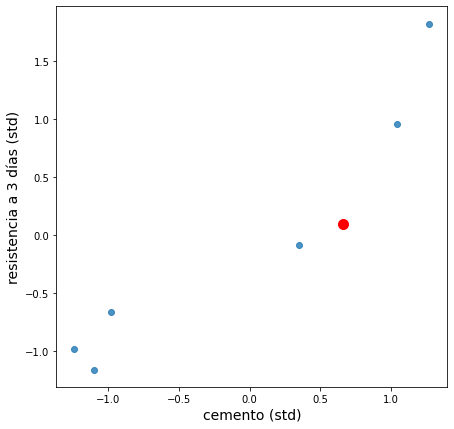

In [273]:
ix_out = 3

fig, ax = plt.subplots( figsize=(7,7) )
ax.scatter( x, y, alpha=.8 )
ax.scatter( x[ix_out], y[ix_out], color='r', s=100 )
ax.set_xlabel('cemento (std)', fontsize=14)
ax.set_ylabel('resistencia a 3 días (std)', fontsize=14);

In [274]:
# índices de las observaciones
ixs_out = np.arange( x.size )

# Inicializar
traces_ej4 = []
lppds_out = []
for ix in ixs_out: # voy dejando una obs afuera por vez

  # set de entrenamiento
  xtrain = np.delete( x, ix )
  ytrain = np.delete( y, ix )

  # set de testeo
  xtest = x[ ix ]
  ytest = y[ ix ]

  # Ajuste
  xnew = np.arange(-1.5,1.7,0.05)
  model_i = create_poly_model( xtrain, ytrain, 10, degree=1 )
  trace_i = quap( model_i, xnew, n_samples=3000 )

  # lppd de la obsrevación que quedó afuer
  mu_pred = trace_i.posterior_predictive['mu']
  s_pred = trace_i.posterior['log_sigma']
  ix_obj = np.where( xnew >= xtest )[0][0]
  lppd_out_i = np.mean( np.exp( st.norm.logpdf( ytest, loc=mu_pred[:,:,ix_obj],
                                       scale=np.exp(s_pred) )) )
  lppd_out_i = np.log(lppd_out_i)

  traces_ej4 += [trace_i]
  lppds_out += [lppd_out_i]

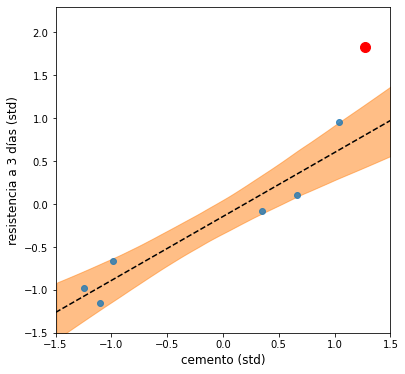

In [275]:
fig, ax = plt.subplots( figsize=(6,6) )

i = 5

mu_media = traces_ej4[i].posterior_predictive['mu'].mean(['chain','draw']).T
ax.plot( xnew, mu_media, 'k--')

# HDI de mu
az.plot_hdi( xnew, traces_ej4[i].posterior_predictive['mu'], color='C1', ax=ax )

# Observaciones
ax.scatter( x, y, alpha=.8, color='C0' )
ax.scatter( x[ixs_out[i]], y[ixs_out[i]], color='r', s=100 )

ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,2.3])
ax.set_xlabel('cemento (std)', fontsize=12)
ax.set_ylabel('resistencia a 3 días (std)', fontsize=12);

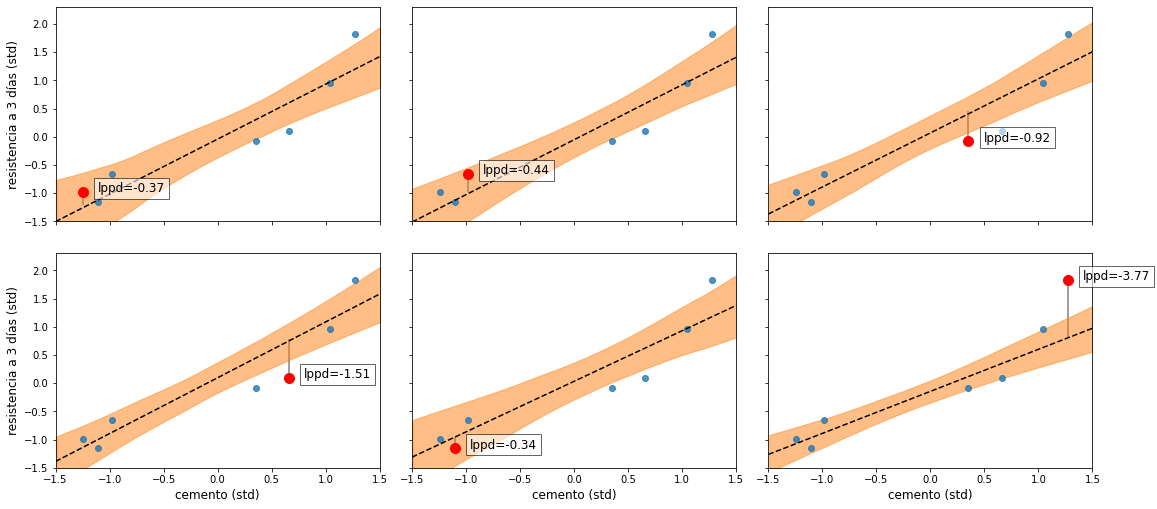

In [276]:
fig, ax = plt.subplots( figsize=(18,8), ncols=3, nrows=2, sharey=True, sharex=True )
fig.subplots_adjust( left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1,
                     hspace=0.15)

for i in range(len(traces_ej4)-1):
  row = i//3
  col = i - row * 3
  # Línea media
  mu_media = traces_ej4[i].posterior_predictive['mu'].mean(['chain','draw']).T
  ax[row,col].plot( xnew, mu_media, 'k--')

  # HDI de mu
  az.plot_hdi( xnew, traces_ej4[i].posterior_predictive['mu'], color='C1', ax=ax[row,col] )

  # Observaciones
  ax[row,col].scatter( x, y, alpha=.8, color='C0' )
  ax[row,col].scatter( x[ixs_out[i]], y[ixs_out[i]], color='r', s=100 )
  ax[row,col].vlines( x=x[ixs_out[i]], ymin=y[ixs_out[i]],
                      ymax=mu_media[np.where( xnew >= x[ixs_out[i]] )[0][0]],
                      color='gray', linestyle='-', zorder=0 )

  # MSE
  # mse_out = ( y[ixs_out[i]] - mu_media[np.where( xnew >= x[ixs_out[i]] )[0][0]].values )**2
  ax[row,col].annotate( 'lppd={:.2f}'.format(lppds_out[i]), 
                        xy=(x[ixs_out[i]], y[ixs_out[i]]),
                        fontsize=12,
                        xytext=(15, 0), textcoords='offset points',
                        bbox=dict(facecolor='w', alpha=.6) )

  # Formateo
  ax[row,col].set_xlim([-1.5,1.5])
  ax[row,col].set_ylim([-1.5,2.3])
  if row==1: ax[row,col].set_xlabel('cemento (std)', fontsize=12)
  if col==0: ax[row,col].set_ylabel('resistencia a 3 días (std)', fontsize=12)


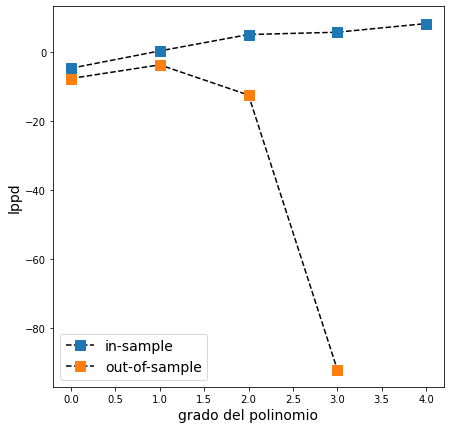

In [277]:
lppd_in = np.array([-4.74,0.27,5.01,5.68,8.18])
lppd_out = np.array([-7.71,-3.76,-12.5,-91.9,-np.inf])

fig, ax = plt.subplots( figsize=(7,7) )

ax.plot( lppd_in, 'k--', marker='s', label='in-sample',
         markerfacecolor='C0', markeredgecolor='C0', markersize=10)
ax.plot( lppd_out, 'k--', marker='s', label='out-of-sample',
         markerfacecolor='C1', markeredgecolor='C1', markersize=10)

ax.set_xlabel('grado del polinomio', fontsize=14 )
ax.set_ylabel('lppd', fontsize=14)
ax.legend( fontsize=14 );

## Ejemplo 4: K-Fold CV 

In [22]:
df_hormigon['w/c'] = df_hormigon['Water  (kg/m3)'] / df_hormigon['Cement (kg/m3)']
x = df_hormigon['w/c'].to_numpy()
x = (x-x.mean())/x.std()
y = df_hormigon['Concrete compressive strength (MPa) '].to_numpy()
y = (y-y.mean())/y.std()

In [23]:
k = 6
indices = np.arange( x.size )
np.random.shuffle(indices) # mezclar todas las filas
folds = np.array_split(indices, k)

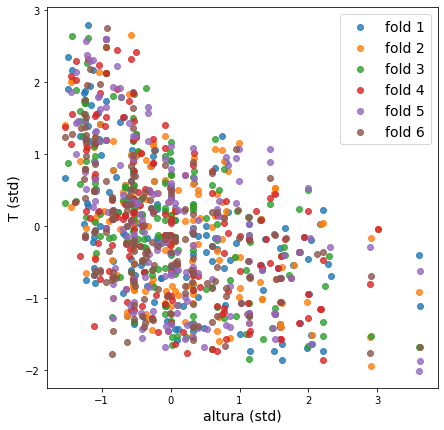

In [24]:
fig, ax = plt.subplots( figsize=(7,7) )
for i in range(k):
  ax.scatter( x[folds[i]], y[folds[i]], alpha=.8, label='fold {}'.format(str(i+1)))
ax.set_xlabel('altura (std)', fontsize=14)
ax.set_ylabel('T (std)', fontsize=14)
ax.legend( loc='best', fontsize=14 );

In [26]:
# Inicializar diccionarios
traces_ej51 = {}
lppds_out_51 = {}

# Grados del polinomio
grados = [1,2,3,4,5]

for j in grados: # grado del polinomio

  # Inicializar listas de trazas y lppds
  traces_ej51[j] = []
  lppds_out_51[j] = []

  for i in range(k):  # fold

    # set de entrenamiento
    xtrain = np.delete( x, folds[i] )
    ytrain = np.delete( y, folds[i] )

    # set de testing
    xtest = x[ folds[i] ]
    ytest = y[ folds[i] ]

    # Ajuste
    model_i = create_poly_model( xtrain, ytrain, 10, degree=j )
    # trace_i = pm.sample( 3000, tune=2000, cores=2, model=model_i )
    trace_i = run_mcmc( model_i, xtest, mu='mu', y='y' )

    # lppd test
    mu_pred = trace_i.posterior_predictive['mu']
    s_pred = trace_i.posterior['log_sigma']
    aux_1 = np.array([st.norm.logpdf( ytest[i], loc=mu_pred[:,:,i],
                          scale=np.exp(s_pred) ) for i in range(xtest.size) ])
    aux_2 = np.mean( np.mean( np.exp( aux_1 ), axis=1), axis=1)
    aux_3 = np.log( aux_2 )

    traces_ej51[j] += [trace_i]
    lppds_out_51[j] += [aux_3.sum()]

In [27]:
# LPPD para cada modelo polinómico sumando los lppds para cada fold
lppd_pols = []
for key, value in lppds_out_51.items():
  lppd_pols += [np.array(value).sum()]

lppd_pols

[-1317.5149517176421,
 -1286.349615087419,
 -1273.0989617060252,
 -1273.6142852674773,
 -1273.6594689981284]

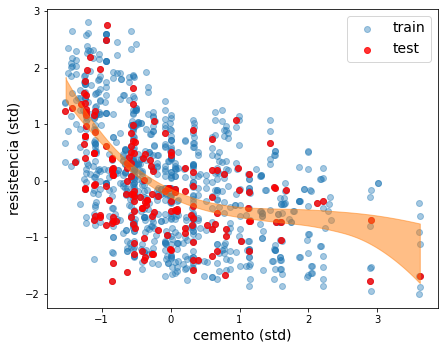

In [28]:
# Gráfico de un modelo para un polinomio dado y un fold dado
fig, ax = plt.subplots( figsize=(7,5.5) )

i = 5 # fold
j = 3 # grado

# Observaciones
ax.scatter( x, y, alpha=.4, label='train' )
ax.scatter( x[folds[i]], y[folds[i]], alpha=.8, color='r', label='test')

# Línea media
xtrain = np.delete( x, folds[i] )
mu_pred = traces_ej51[j][i].posterior['mu']
ix = np.argsort(xtrain)
# ax.plot( xtrain[ix], mu_pred.mean(['chain','draw'])[ix].T, 'k--')
# HDI de mu
az.plot_hdi( xtrain, mu_pred, color='C1', ax=ax )

# Formateo
ax.set_xlabel('cemento (std)', fontsize=14)
ax.set_ylabel('resistencia (std)', fontsize=14)
ax.legend( fontsize=14 );

In [81]:
# Corremos los modelos polinómicos con TODAS las obsrevaciones para calcular los IC
traces_ej52 = []
grados = [1,2,3,4,5]
for j in grados:
    # Crear modelo
    model_i = create_poly_model( x, y, 10, degree=j )
    # Obtener simulaciones posteriores de los parámetros
    trace_i = pm.sample( 3000, tune=2000, cores=2, model=model_i )
    # Obtener simulaciones posteriores de y
    pm.sample_posterior_predictive( trace_i, extend_inferencedata=True,
                                    model=model_i )
    traces_ej52 += [trace_i]

In [307]:
# Comparamos los modelos polinómicos mediane PSIS-LOOCV
model_comp = {str(grados[i]):traces_ej52[i] for i in range(len(grados))}
az_comp_loo = az.compare( model_comp, ic='loo' )

In [303]:
az_comp_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
3,0,-1269.966855,4.150933,0.000000,0.935419,19.751094,0.000000,False,log
4,1,-1270.325269,4.914582,0.358413,0.064581,19.793466,0.907914,False,log
5,2,-1271.074800,5.829936,1.107944,0.000000,19.709263,1.082771,False,log
2,3,-1284.792091,3.818618,14.825236,0.000000,19.426435,4.903976,False,log
1,4,-1315.732611,2.690756,45.765756,0.000000,19.373659,8.919036,False,log


In [304]:
# Comparamos los modelos polinómicos mediante waic
az_comp_waic = az.compare( model_comp, ic='waic' )
az_comp_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
3,0,-1269.958763,4.142841,0.000000,9.326177e-01,19.750972,0.000000,False,log
4,1,-1270.314799,4.904112,0.356036,6.738228e-02,19.793314,0.907802,False,log
5,2,-1271.059591,5.814728,1.100828,8.524462e-15,19.709136,1.082340,False,log
2,3,-1284.784135,3.810661,14.825372,9.761062e-15,19.426082,4.902849,False,log
1,4,-1315.730107,2.688252,45.771344,0.000000e+00,19.373545,8.919106,False,log


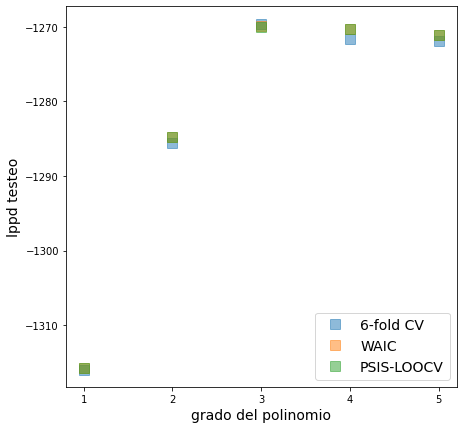

In [305]:
# Graficamos comparación lppd
fig, ax = plt.subplots( figsize=(7,7) )

ax.plot( grados, lppd_pols, 'C0s', label='6-fold CV', markersize=10, alpha=.5 )
ax.plot( az_comp_waic.index.to_list(), az_comp_waic.waic, 'C1s', label='WAIC',
         markersize=10, alpha=.5)
ax.plot( az_comp_loo.index.to_list(), az_comp_loo.loo, 'C2s', label='PSIS-LOOCV',
         markersize=10, alpha=.5)

ax.set_xticks(grados)
ax.set_xlabel( 'grado del polinomio', fontsize=14 )
ax.set_ylabel( 'lppd testeo', fontsize=14 )
ax.legend( loc='lower right', fontsize=14);

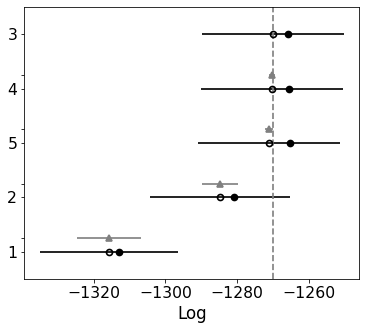

In [308]:
az.plot_compare( az_comp_loo );

## Ejemplo extra: Regularización

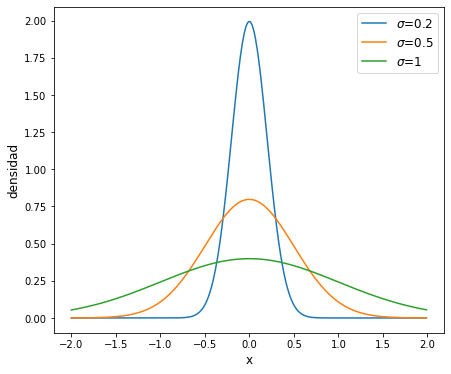

In [349]:
# Normal vs student
xplot = np.arange(-2,2,0.01)
yplot_n = st.norm.pdf( xplot, loc=0, scale=1 )

sigmas = [0.2,0.5,1]

fig, ax = plt.subplots( figsize=(7,6) )

# ax.plot( xplot, yplot_n, label='Normal', color='k' )

for sigma in sigmas:
  ax.plot( xplot, st.norm.pdf( xplot, loc=0, scale=sigma ),
           label=r'$\sigma$={}'.format(sigma))

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('densidad', fontsize=12)
ax.legend( fontsize=12);

## Ejemplo 5: Regresión robusta

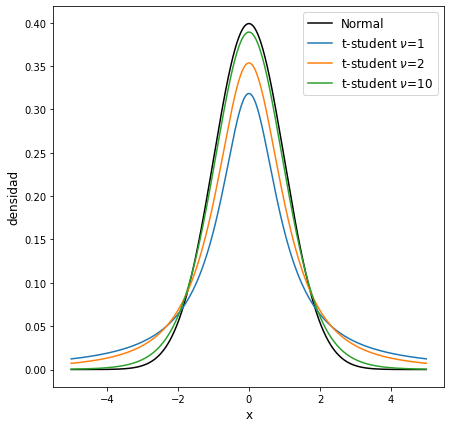

In [320]:
# Normal vs student
xplot = np.arange(-5,5,0.01)
yplot_n = st.norm.pdf( xplot, loc=0, scale=1 )

nus = [1,2,10]

fig, ax = plt.subplots( figsize=(7,7) )

ax.plot( xplot, yplot_n, label='Normal', color='k' )

for nu in nus:
  ax.plot( xplot, st.t.pdf( xplot, df=nu, loc=0, scale=1 ),
           label=r't-student $\nu$={}'.format(nu))

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('densidad', fontsize=12)
ax.legend( fontsize=12);

In [321]:
# Dataset sintético
N = 50
x = st.uniform.rvs( size=N, loc=0, scale=10 )
y = 0.5*x + 2 + st.norm.rvs( size=N, scale=0.1 )
# outliers
N_out = 4
np.random.seed(5234)
ix_out = np.random.choice( x.size, size=N_out, replace=False )
y[ix_out] =  0.5*x[ix_out] + 2 + 4*st.norm.rvs( size=N_out, loc=1, scale=0.1 )
# standardize
x = (x-x.mean())/x.std()
y = (y-y.mean())/y.std()

Text(0, 0.5, 'y (std)')

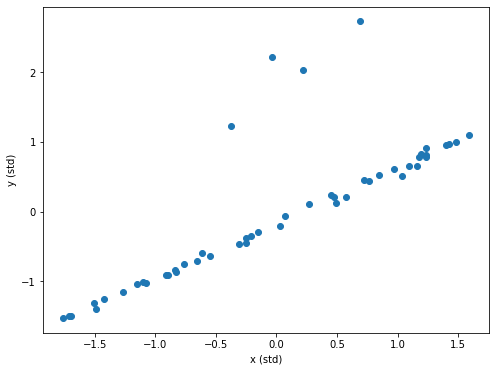

In [323]:
fig, ax = plt.subplots( figsize=(8,6) )
ax.plot( x, y, 'C0o' )
ax.set_xlabel('x (std)')
ax.set_ylabel('y (std)')

In [326]:
with pm.Model() as model:
    
    # Data modificable
    X = pm.MutableData( 'X', x )

    # Priors
    alpha = pm.Normal( "alpha", mu=0, sigma=2 )
    beta = pm.Normal( "beta", mu=0, sigma=2 )
    log_sigma = pm.Normal( "log_sigma", mu=0, sigma=1 )
    
    # Mean
    mu = pm.Deterministic( 'mu', alpha + beta * x )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=np.exp(log_sigma), observed=y )
    
    # Posterior de los parámetros
    trace_61 = pm.sample( 3000, tune=2000, cores=2 )
  
    # Posterior predictive
    pm.sample_posterior_predictive( trace_61, extend_inferencedata=True);

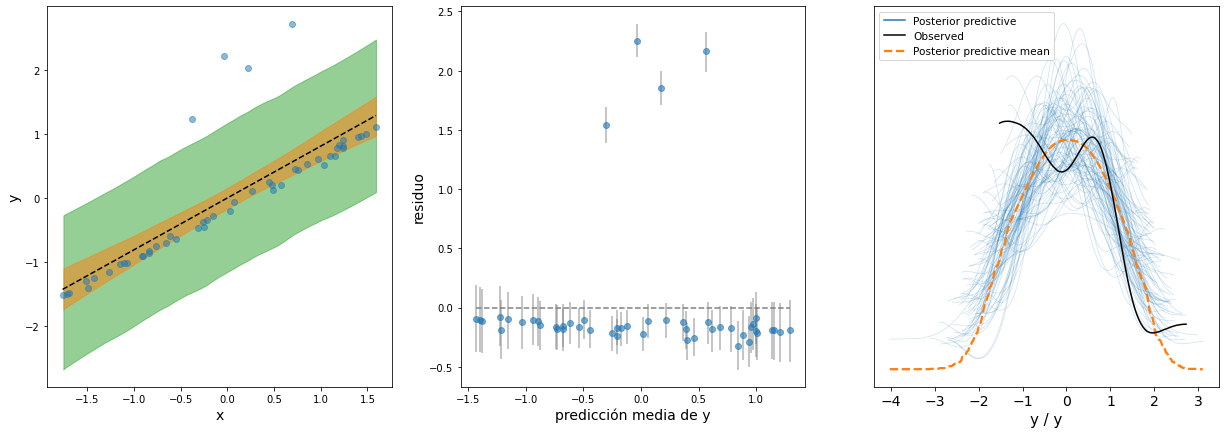

In [329]:
fig, ax = plt.subplots( figsize=(21,7), ncols=3 )
_ = plot_lm( trace_61, x, y, 'mu', 'y', ax=ax[0] )
_ = residuals_plot( trace_61, y, 'mu', ax=ax[1])
_ = az.plot_ppc( trace_61, num_pp_samples=100, ax=ax[2], textsize=14 );

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


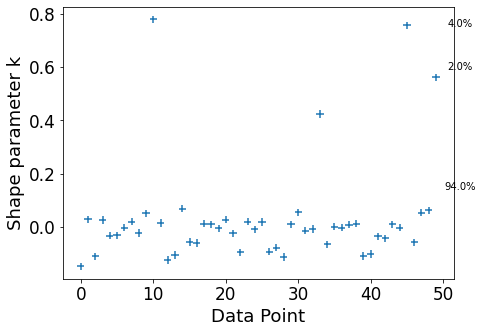

In [332]:
loo_normal = az.loo( trace_61, pointwise=True)
az.plot_khat(loo_normal, show_bins=True, figsize=(7,5) );

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Text(0, 0.5, 'waic i')

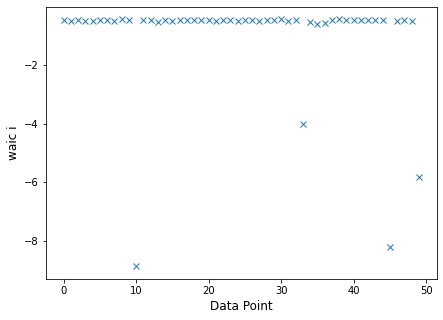

In [335]:
az_waic_normal = az.waic( trace_61, pointwise=True)

fig, ax = plt.subplots( figsize=(7,5) )
ax.plot( az_waic_normal.waic_i, 'C0x' )
ax.set_xlabel('Data Point', fontsize=12)
ax.set_ylabel('waic i', fontsize=12)

In [336]:
with pm.Model() as model:
    
    # Data modificable
    X = pm.MutableData( 'X', x )

    # Priors
    alpha = pm.Normal( "alpha", mu=0, sigma=2 )
    beta = pm.Normal( "beta", mu=0, sigma=2 )
    log_sigma = pm.Normal( "log_sigma", mu=0, sigma=1 )
    nu = pm.Exponential("nu", lam=1)
    
    # Mean
    mu = pm.Deterministic( 'mu', alpha + beta * x )
    
    # Modelo
    Y = pm.StudentT( "y", mu=mu, sigma=np.exp(log_sigma), nu=nu, observed=y )
    
    # Posterior de los parámetros
    trace_62 = pm.sample( 3000, tune=2000, cores=2 )
  
    # Posterior predictive
    pm.sample_posterior_predictive( trace_62, extend_inferencedata=True);

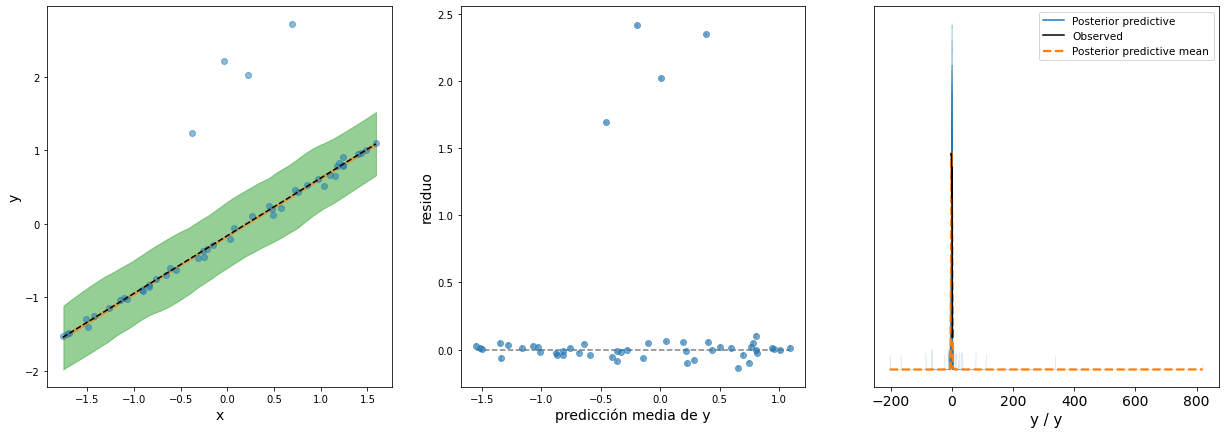

In [337]:
fig, ax = plt.subplots( figsize=(21,7), ncols=3 )
_ = plot_lm( trace_62, x, y, 'mu', 'y', ax=ax[0] )
_ = residuals_plot( trace_62, y, 'mu', ax=ax[1])
_ = az.plot_ppc( trace_62, num_pp_samples=100, ax=ax[2], textsize=14 );

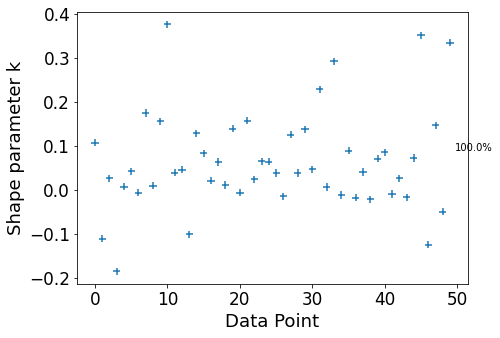

In [338]:
loo_t = az.loo( trace_62, pointwise=True)
az.plot_khat(loo_t, show_bins=True, figsize=(7,5) );

Text(0, 0.5, 'waic i')

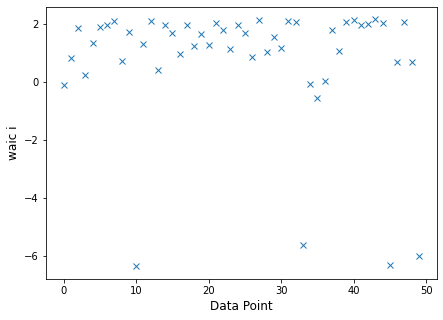

In [339]:
az_waic_t = az.waic( trace_62, pointwise=True)

fig, ax = plt.subplots( figsize=(7,5) )
ax.plot( az_waic_t.waic_i, 'C0x' )
ax.set_xlabel('Data Point', fontsize=12)
ax.set_ylabel('waic i', fontsize=12)

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


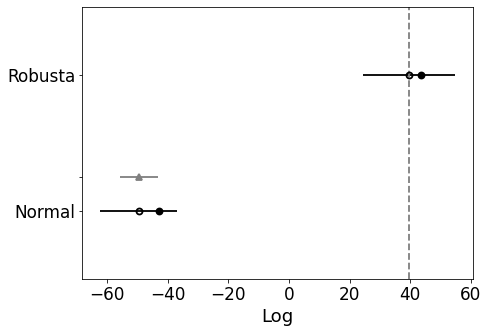

In [341]:
model_comp = {'Normal':trace_61, 'Robusta':trace_62}
az_comp = az.compare( model_comp, ic='loo' )
az.plot_compare( az_comp, figsize=(7,5) )